# 8: L2- and L1-Regularization

## Imports

In [1]:
import os
import sys

sys.path.append("code/.")
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import numpy.linalg as npla
import numpy.random as npr
import pandas as pd
from IPython.display import display
from ipywidgets import interact, interactive
from plotting_functions import *
from sklearn import datasets
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

### Outlines

- Explain the general idea of L2 regularization.
- Explain the relation between the size of regression weights and overfitting. 
- Explain the general idea of L1-regularization.
- Learn to be skeptical about interpretation of the coefficients. 
- Use L1-regularization (Lasso) using `sklearn`. 
- Discuss sparsity in L1-regularization. 
- Compare L0-, L1-, and L2-regularization.
- Use L1 regularization for feature selection. 
- Explain the importance of scaling when using L1- and L2-regularization
- Briefly explain how L1 and L2 regularization behave in the presence of collinear features.   

## Recap

- Regularization is a technique for controlling model complexity. 
- The idea is to add a penalty term in the loss function. 
- Regularization tends to **increase training error**.
- Regularization tends to **decrease validation error**. 

### L2-regularization

- Standard regularization strategy is L2-regularization. 

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$

- Regularization parameter $\lambda$ controls the strength of regularization. 
    - bigger $\lambda$ $\rightarrow$ more regularization $\rightarrow$ lower weights

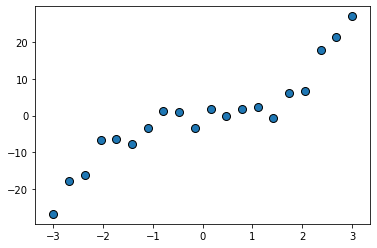

In [2]:
n = 20
np.random.seed(4)
X_train = np.linspace(-3, 3, n)
y_train = X_train ** 3 + npr.randn(n) * 3

X_valid = np.linspace(-3, 3, n)
y_valid = X_valid ** 3 + npr.randn(n) * 3

# transforming the data to include another axis
X_train = X_train[:, np.newaxis]
y_train = y_train[:, np.newaxis]

X_valid = X_valid[:, np.newaxis]
y_valid = y_valid[:, np.newaxis]

# plt.scatter(X_train, y_train, color="blue")
mglearn.discrete_scatter(X_train, y_train, s=8);

Let's fit linear regression with a polynomial of degree 18 on this data. 

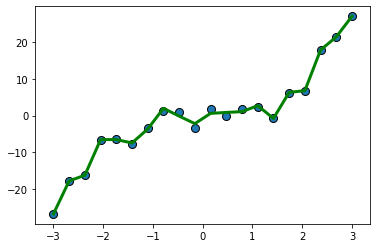

In [3]:
degree = 18
mglearn.discrete_scatter(X_train, y_train, s=8)
pipe_poly_lr = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
pipe_poly_lr.fit(X_train, y_train)
plt.plot(X_train, pipe_poly_lr.predict(X_train), color="green", linewidth=3);

In [4]:
w_lr = pipe_poly_lr.named_steps["linearregression"].coef_.flatten()
feature_names = pipe_poly_lr.named_steps["polynomialfeatures"].get_feature_names_out()

In [5]:
df = pd.DataFrame(w_lr, index=feature_names, columns=["lr_weights"])
df

,lr_weights
1,0.000000
x0,10.446187
x0^2,6.186111
x0^3,-66.790372
x0^4,0.048736
x0^5,135.929795
x0^6,-7.181033
x0^7,-122.474687
x0^8,1.265846
x0^9,58.272401


- Some weights in this degree 18 polynomial are big. 
- If we regularize the weights, the this polynomial of degree 18 will be less sensitive to the data. 

Let's fit `Ridge` with a polynomial of degree 18 on this data. 

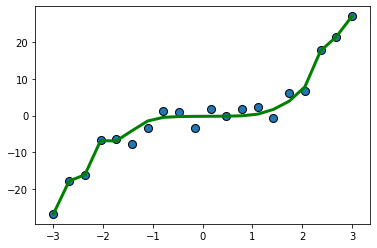

In [6]:
degree = 18
mglearn.discrete_scatter(X_train, y_train, s=8)
pipe_poly_r = make_pipeline(PolynomialFeatures(degree=degree), Ridge(alpha=100))
pipe_poly_r.fit(X_train, y_train)
plt.plot(X_train, pipe_poly_r.predict(X_train), color="green", linewidth=3);

In [7]:
df["ridge_weights"] = pipe_poly_r.named_steps["ridge"].coef_.flatten()
df

,lr_weights,ridge_weights
1,0.000000,0.000000
x0,10.446187,0.076271
x0^2,6.186111,-0.032400
x0^3,-66.790372,0.112943
x0^4,0.048736,-0.066220
x0^5,135.929795,0.170757
x0^6,-7.181033,-0.081811
x0^7,-122.474687,0.210630
x0^8,1.265846,-0.055938
x0^9,58.272401,0.123522


In [8]:
df.iloc[5:8, :]

,lr_weights,ridge_weights
x0^5,135.929795,0.170757
x0^6,-7.181033,-0.081811
x0^7,-122.474687,0.210630


- Example:
    $$\hat{y_i} = 135 \times x0^5 - 122 \times x0^7 + ...$$ vs. 
    
    $$\hat{y_i} = 0.17 \times x0^5 + 0.21 \times x0^7 + ...$$
    
- Seems like the signs of the coefficients are also changing with regularization... Illustrates that the interpretations of coefficients of linear models should always be taken with a grain of salt.

<br><br><br><br>

## More on L2 regularization

- With regularization you find the balance between low training error vs. small weights. 

### L2-Regularization "Shrinking" Example


<img src='img/l2_shrinking_example.png' width="900" height="700" />

[Source](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L17.pdf)

- We get least squares with $\lambda = 0$.
- $\lVert Xw - y\rVert^2$ increases with $\lambda$, and $\lVert w\rVert^2$ decreases with λ.
    - Though individual $w_j$ can increase or decrease with lambda because we use the L2-norm, the large ones decrease the most.

### Let's bring back `sklearn's` California housing dataset

In [9]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

housing = fetch_california_housing(as_frame=True)
X = housing["data"]
X = MinMaxScaler().fit_transform(housing.data)
pf = PolynomialFeatures(degree=2, include_bias=False)
X = pf.fit_transform(X)
y = housing["target"]

In [10]:
X.shape

(20640, 44)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### The weights become smaller but never become zero

- Strong regularization means the results are not too sensitive to the training data. 
- We are keeping the complexity of the model but making it less sensitive to the feature values! 
- As `alpha` goes up, we increase the regularization strength. 
- The weights become smaller and smaller. 

In [15]:
ridge01 = Ridge(alpha=0.01).fit(X_train, y_train)
ridge1 = Ridge().fit(X_train, y_train)
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
ridge100 = Ridge(alpha=100).fit(X_train, y_train)
ridge1000 = Ridge(alpha=1000).fit(X_train, y_train)

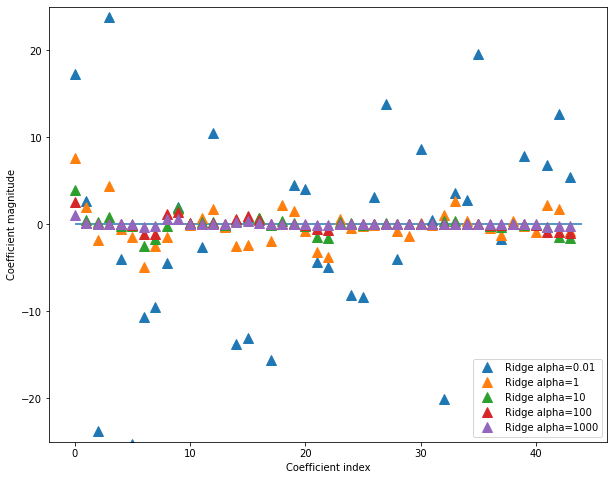

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(ridge01.coef_, "^", markersize=10, label="Ridge alpha=0.01")
plt.plot(ridge1.coef_, "^", markersize=10, label="Ridge alpha=1")
plt.plot(ridge10.coef_, "^", markersize=10, label="Ridge alpha=10")
plt.plot(ridge100.coef_, "^", markersize=10, label="Ridge alpha=100")
plt.plot(ridge1000.coef_, "^", markersize=10, label="Ridge alpha=1000")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines(0, 0, len(lr.coef_))
plt.ylim(-25, 25)
plt.legend();

Let's try a very large `alpha` value, which is likely to make weights very small. 

In [13]:
lr = LinearRegression().fit(X_train, y_train)
ridge10000 = Ridge(alpha=10000).fit(X_train, y_train)
print("Total number of features", X_train.shape[1])
print("Number of non-zero weights: ", np.sum(ridge10000.coef_ != 0))

Total number of features 44
Number of non-zero weights:  44


All features have non-zero weights. 

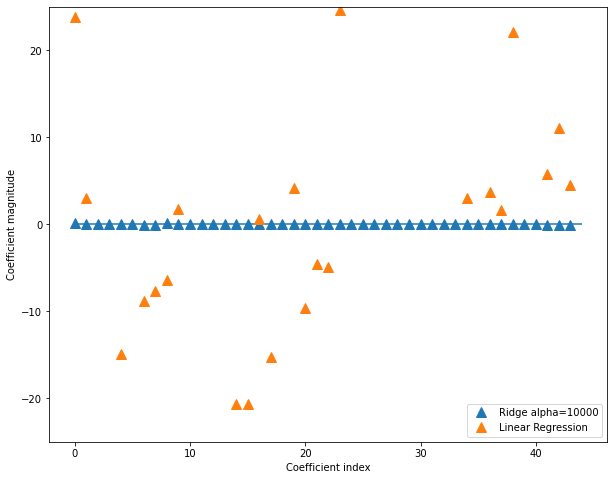

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(ridge10000.coef_, "^", markersize=10, label="Ridge alpha=10000")
plt.plot(lr.coef_, "^", markersize=10, label="Linear Regression")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines(0, 0, len(lr.coef_))
plt.ylim(-25, 25)
plt.legend();

The coefficients are very close to zero but not exactly zero. That said, they won't have much impact on prediction. 

### Regularization path

- Weights shrink and converge to zero as $\lambda$ grows but they do not become exactly 0. 
- The reason for this is the shape and smoothness of the function when we add L2-regularization. 

![](img/sparsity_regularization.png)
<!-- <img src='img/sparsity_regularization.png' width="1000" height="1000" /> -->

For more details refer to [CPSC 340 notes](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L18.pdf). 

### Regularization path

- Imagine that $w_j = 0.000001$. The penalty for this $w_j$ is $0.000000000001$, i.e., a very tiny number. So there is less "incentive" in terms of decreasing the loss to set it to zero. The incentive (slope) is smaller and smaller as we approach 0 and therefore the coefficients do not become exactly 0. The slope (derivative) is going to go to zero smoothly, which provides us the incentive to move to zero during optimization. 

![](img/regularization_path.png)
<!-- <img src='img/regularization_path.png' width="700" height="700" /> -->

### Regularization learning curves

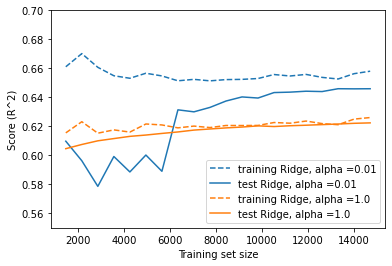

In [17]:
plot_learning_curve(Ridge(alpha=0.01), X_train, y_train)
plot_learning_curve(Ridge(alpha=1.0), X_train, y_train)
plt.legend();

- As one would expect, the training score is higher than the test score for all dataset sizes
- Training score of `Ridge` with `alpha=0.01` > Training score of `Ridge` with `alpha=1` (more regularization)
- However, the test score of `Ridge` with `alpha=1` > Test score of `Ridge` with `alpha=0.01` **for smaller training sizes.**
- As more and more data becomes available to the model, both models improve. Ridge with less regularization catches up with ridge with more regularization and actually performs better. 

> Takeaway: Regularization is extremely useful when the dataset is small. It prevents the model from overfitting and gives it a more robust result on the test set.

### How to pick $\lambda$? 

- Theory: as $n$ grows $\lambda$ should be in the range $O(1)$ to $\sqrt{n}$.
- Practice: optimize validation set or cross-validation error.
    - Almost always decreases the test error.

### Should we regularize the y-intercept?

- No! 
    - Why encourage it to be closer to zero? (It could be anywhere.)
    - You should be allowed to shift function up/down globally.
- Yes! 
    - Useful for optimization; It makes the solution unique and it easier to compute $w$    
- Compromise: regularize by a smaller amount than other variables.
    $$f(w) = \lVert Xw + w_0 - y\rVert^2 + \frac{\lambda_1}{2}\lVert w\rVert^2 + \frac{\lambda_2}{2}w_0^2$$  

### Some properties of L2-regularization

1. Solution $w$ is unique. Again, it has to do with the smoothness of the function. 
    - We are not going into mathematical details. If interested see [slide 20](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L17.pdf).
2. **Almost always improves the validation error.** 
3. No collinearity issues.
4. Less sensitive to changes in $X$.
5. Gradient descent (optimization algorithm) converges faster (bigger $\lambda$ means fewer iterations).
6. Worst case: just set $\lambda$ small and get the same performance

### Summary: L2-regularization 

- Change the loss function by adding a continuous L2-penalty on the model complexity. 
- Best parameter $\lambda$ almost already leads to improved validation error.
    - L2-regularized least squares is also called "ridge regression". 
    - Can be solved as a linear system like least squares.
- Some benefits of L2 regularization  
    - Solution is unique.
    - Less sensitive to data.
    - Fast. 

### L2-regularization

```{admonition} Exercise 7.2 True/False (Recap)
1. Introducing L2 regularization to the model means making it less sensitive to changes in $X$.
2. Introducing L2 regularization to the model can results in worse performance on the training set. 
3. L2 regularization shrinks the weights but all $w_j$s tend to be non-zero.
```

## L1 regularization

- An alternative to `Ridge` (L2-regularization for least squares) is `Lasso`.
- Instead of L0- or L2-norm, regularize with L1-norm. 

$$f(w) = \frac{1}{2}\sum_i^n(w^TX_i - y_i)^2 + \frac{\lambda}{2}\sum_j^d \lvert w_j \lvert\text{ or }$$ 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$


- $\lambda \rightarrow$ regularization strength
- $\lVert w\rVert_1 \rightarrow$  L1-norm of $w$  
- Objective balances getting low error vs. having small values for $w_j$


### Similarities with L2-regularization

- L1-regularization 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$

- L2-regularization 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$

- Both shrink weights.
- Both result in lower validation error. 

### Terminology and notation: Ridge and Lasso

- Linear regression model that uses L2 regularization is called **Ridge** or Tikhonov regularization.
    - [`scikit-learn` Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html?highlight=ridge#sklearn.linear_model.Ridge)
- Linear regression model that uses L1 regularization is called **Lasso**. 
    - [`scikit-learn` Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso)
    > class sklearn.linear_model.Lasso(alpha=1.0, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')



### L1-regularization 

- The consequence of using L1-norm is that some features are exactly zero, which means that the features are entirely ignored by the model. 
- This can be considered as a form of feature selection!! 
- L1-regularization simultaneously regularizes and selects features.
- Very fast alternative to search and score methods

Let's apply `Lasso` on the California housing data. 

In [18]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Training set score: 0.00
Test set score: -0.00
Number of features used: 0


- That's strange. It's not using any features -- like dummy model. It's underfitting. 
- Similar to `Ridge` it also has a regularization hyperparameter `alpha`. 
- Let's decrease it to reduce underfitting. 

In [19]:
r = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(r.score(X_train, y_train)))
print("Test set score: {:.2f}".format(r.score(X_test, y_test)))
print("Number of features used:", np.sum(r.coef_ != 0))

Training set score: 0.63
Test set score: 0.61
Number of features used: 44


In [20]:
lasso = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Training set score: 0.64
Test set score: 0.62
Number of features used: 19


- The scores are a bit better than `Ridge` with only 19/44 features!! 
- If `alpha` is too low, we reduce the effect of overfitting and the results are similar to linear regression. 

Let's plot coefficients of `Lasso`. 

In [21]:
lasso0001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)
lasso001 = Lasso(alpha=0.001).fit(X_train, y_train)
lasso = Lasso(alpha=1).fit(X_train, y_train)

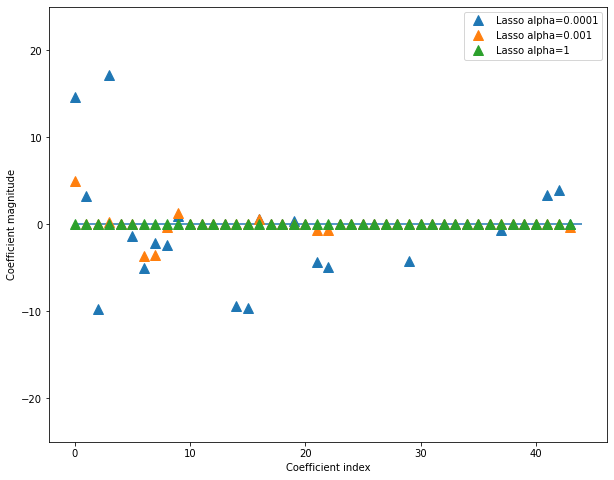

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(lasso0001.coef_, "^", markersize=10, label="Lasso alpha=0.0001")
plt.plot(lasso001.coef_, "^", markersize=10, label="Lasso alpha=0.001")
plt.plot(lasso.coef_, "^", markersize=10, label="Lasso alpha=1")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines(0, 0, len(lr.coef_))
plt.ylim(-25, 25)
plt.legend();

- For `alpha = 1` most of the coefficients are zero. 
- With smaller values of `alpha` we get an unregularized model. 

### Terminology and notation: Sparsity 

- We say a linear function is sparse if most of the coefficients are zero. 
- Example: Here only 2 out of 8 coefficients are non-zero and so it is a sparse function. 
$$0x_1 + 0.45 x_2 + 0  x_3 + 0x_4 + 1.2x_5 + 0x_6 + 0x_7 + 0x_8$$
- L0- and L1-regularization encourage sparsity. 

### Example: L0 vs. L1 vs. L2

Consider problem where 3 vectors can get minimum training error:

$$w^1 = \begin{bmatrix}100 \\0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- Without regularization, we could choose any of these 3.
- They all have same error, so regularization will "break tie".
- Which one would you choose with each of L0, L1, L2 regularization?

### Which one would you choose with L0 regularization? 

$$w^1 = \begin{bmatrix}100 \\-0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- With L0 regularization, you would choose $w^2$
    - $\lVert w^1\rVert_0 = 2$
    - $\lVert w^2\rVert_0 = 1$
    - $\lVert w^3\rVert_0 = 2$

### Which one would you choose with L1 regularization? 

$$w^1 = \begin{bmatrix}100 \\0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- With L1 regularization, you would choose $w^2$. 
    - $\lVert w^1\rVert_1 = 100.02$
    - $\lVert w^2\rVert_1 = 100$
    - $\lVert w^3\rVert_1 = 100.01$
- L1-regularization focuses on decreasing all $w_j$ until they are 0. 

### Which one would you choose with L2 regularization? 

$$w^1 = \begin{bmatrix}100 \\0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- With L1 regularization, you would choose $w^3$. 
    - $\lVert w^1\rVert_2^2 = (100)^2 + (0.02)^2 = 10000.0004$
    - $\lVert w^2\rVert_2^2 = (100)^2 = 10000$
    - $\lVert w^3\rVert_2^2 = (99.99)^2 + (0.02)^2 = 9998.0005$
    
- L2-regularization focuses on decreasing largest $w_j$ smaller    

### Some properties of L1 regularization

1. Almost always improves the validation error. 
2. Can learn with exponential number of irrelevant features.
3. Less sensitive to changes in $X$.
4. The solution is not unique. (If interested in more explanation on this, see slide 43 in [this slide deck](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L18.pdf).)

### Feature selection using L1 regularization 

- Feature selection methods we have seen so far: 
    - RFE
    - Search and score with L0-regularization (e.g., forward search)
- An effective way of feature selection: L1-regularization 

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV

housing = fetch_california_housing(as_frame=True)
X = housing["data"]
y = housing["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipe_l1_rf = make_pipeline(
    StandardScaler(),
    SelectFromModel(Lasso(alpha=0.01, max_iter=100000)),
    RandomForestRegressor(),
)

X.shape

(20640, 8)

In [24]:
pipe_l1_rf.fit(X_train, y_train)
pipe_l1_rf.score(X_train, y_train)

0.972911174947398

In [25]:
print("Training set score: {:.2f}".format(pipe_l1_rf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(pipe_l1_rf.score(X_test, y_test)))

Training set score: 0.97
Test set score: 0.79


In [26]:
print(
    "Number of features used:",
    np.sum(pipe_l1_rf.named_steps["selectfrommodel"].estimator_.coef_ != 0),
)

Number of features used: 7


<br><br><br><br>

## Using regularized models 

### Regularized logistic regression

- Regularization is not limited to least squares. 
- We can add L1 and L2 penalty terms in other loss functions as well. 
- Let's look at logistic regression with L1- and L2-regularization.

In [27]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
# print(breast_cancer.keys())
# print(breast_cancer.DESCR)

In [28]:
breast_cancer_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer_df["target"] = breast_cancer.target
train_df, test_df = train_test_split(breast_cancer_df, test_size=0.2, random_state=2)

X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [29]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
560,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,...,15.30,33.17,100.20,706.7,0.1241,0.22640,0.1326,0.10480,0.2250,0.08321
428,11.13,16.62,70.47,381.1,0.08151,0.03834,0.01369,0.01370,0.1511,0.06148,...,11.68,20.29,74.35,421.1,0.1030,0.06219,0.0458,0.04044,0.2383,0.07083
198,19.18,22.49,127.50,1148.0,0.08523,0.14280,0.11140,0.06772,0.1767,0.05529,...,23.36,32.06,166.40,1688.0,0.1322,0.56010,0.3865,0.17080,0.3193,0.09221
203,13.81,23.75,91.56,597.8,0.13230,0.17680,0.15580,0.09176,0.2251,0.07421,...,19.20,41.85,128.50,1153.0,0.2226,0.52090,0.4646,0.20130,0.4432,0.10860
41,10.95,21.35,71.90,371.1,0.12270,0.12180,0.10440,0.05669,0.1895,0.06870,...,12.84,35.34,87.22,514.0,0.1909,0.26980,0.4023,0.14240,0.2964,0.09606


In [30]:
y_train.value_counts(normalize=True)

1    0.632967
0    0.367033
Name: target, dtype: float64

In [31]:
from sklearn.metrics import f1_score, make_scorer, recall_score

custom_scorer = make_scorer(
    f1_score, pos_label=0
)  # note the syntax to change the positive label for f1 score
scoring_metric = custom_scorer

results_classification = {}

Let's try `DummyClassifier`

In [32]:
dummy = DummyClassifier()
results_classification["dummy"] = mean_std_cross_val_scores(
    dummy,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)
pd.DataFrame(results_classification)

,dummy
fit_time,0.001 (+/- 0.000)
score_time,0.002 (+/- 0.001)
test_score,0.000 (+/- 0.000)
train_score,0.000 (+/- 0.000)


- In `sklearn`, by default logistic regression uses L2 regularization. 
- The `C` hyperparameter decides the strength of regularization. 
- Unfortunately, interpretation of `C` is inverse of `lambda`. 

> From the document:
C : float, default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
Specify the norm of the penalty:

- 'none': no penalty is added;

- 'l2': add a L2 penalty term and it is the default choice;

- 'l1': add a L1 penalty term;

- 'elasticnet': both L1 and L2 penalty terms are added.

In [34]:
pipe_lgr_l2 = make_pipeline(StandardScaler(), LogisticRegression())
results_classification["Logistic Regression L2"] = mean_std_cross_val_scores(
    pipe_lgr_l2, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [35]:
pd.DataFrame(results_classification)

,dummy,Logistic Regression L2
fit_time,0.001 (+/- 0.000),0.016 (+/- 0.005)
score_time,0.002 (+/- 0.001),0.003 (+/- 0.001)
test_score,0.000 (+/- 0.000),0.970 (+/- 0.011)
train_score,0.000 (+/- 0.000),0.985 (+/- 0.005)


Weights are small but all of them are non-zero. 

In [36]:
pipe_lgr_l2.fit(X_train, y_train)
l2_coefs = pipe_lgr_l2.named_steps["logisticregression"].coef_.flatten()
df = pd.DataFrame(l2_coefs, index=X_train.columns, columns=["l2_coefs"])
df

,l2_coefs
mean radius,-0.539854
mean texture,-0.252141
mean perimeter,-0.494560
mean area,-0.610451
mean smoothness,-0.174066
mean compactness,0.577983
mean concavity,-0.658777
mean concave points,-0.980244
mean symmetry,0.119974
mean fractal dimension,0.406479


- Let's try logistic regression with L1 regularization.
- Note that we are using a different solver (optimizer) here because not all solvers support L1-regularization. 

In [37]:
pipe_lgr_l1 = make_pipeline(
    StandardScaler(), LogisticRegression(solver="liblinear", penalty="l1")
)
results_classification["Logistic Regression L1"] = mean_std_cross_val_scores(
    pipe_lgr_l1, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [38]:
pd.DataFrame(results_classification)

,dummy,Logistic Regression L2,Logistic Regression L1
fit_time,0.001 (+/- 0.000),0.016 (+/- 0.005),0.010 (+/- 0.004)
score_time,0.002 (+/- 0.001),0.003 (+/- 0.001),0.004 (+/- 0.002)
test_score,0.000 (+/- 0.000),0.970 (+/- 0.011),0.967 (+/- 0.007)
train_score,0.000 (+/- 0.000),0.985 (+/- 0.005),0.985 (+/- 0.005)


- The scores are more or less the same.

- But L1 regularization is carrying out feature selection; Many coefficients are 0. 
- Similar scores with less features! More interpretable model! 

In [39]:
pipe_lgr_l1.fit(X_train, y_train)
l1_coefs = pipe_lgr_l1.named_steps["logisticregression"].coef_.flatten()
df["l1_coef"] = l1_coefs
df

,l2_coefs,l1_coef
mean radius,-0.539854,0.000000
mean texture,-0.252141,0.000000
mean perimeter,-0.494560,0.000000
mean area,-0.610451,0.000000
mean smoothness,-0.174066,0.000000
mean compactness,0.577983,0.000000
mean concavity,-0.658777,0.000000
mean concave points,-0.980244,-1.353195
mean symmetry,0.119974,0.000000
mean fractal dimension,0.406479,0.277025


We can also carry out feature selection using L1 regularization and pass selected features to another model. 

In [40]:
from lightgbm.sklearn import LGBMClassifier

pipe_lgr_lgbm = make_pipeline(
    StandardScaler(),
    SelectFromModel(LogisticRegression(solver="liblinear", penalty="l1")),
    LGBMClassifier(),
)

In [41]:
results_classification["L1 + LGBM"] = mean_std_cross_val_scores(
    pipe_lgr_lgbm,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)
pd.DataFrame(results_classification)

,dummy,Logistic Regression L2,Logistic Regression L1,L1 + LGBM
fit_time,0.001 (+/- 0.000),0.016 (+/- 0.005),0.010 (+/- 0.004),0.160 (+/- 0.214)
score_time,0.002 (+/- 0.001),0.003 (+/- 0.001),0.004 (+/- 0.002),0.004 (+/- 0.000)
test_score,0.000 (+/- 0.000),0.970 (+/- 0.011),0.967 (+/- 0.007),0.961 (+/- 0.037)
train_score,0.000 (+/- 0.000),0.985 (+/- 0.005),0.985 (+/- 0.005),1.000 (+/- 0.000)


- The score went down a bit this case. But this might help in some other cases.
- The resulting model is using L1 selected features only. 

### How to use regularization with `scikit-learn`: some examples

- Regression
    - Least squares with L2-regularization: [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
    - Least squares with L1-regularization: [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
    - Least squares with L1- and L2-regularization: [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
    - [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR) ($\epsilon$-insensitive loss function)
        - `epsilon = 0` gives us `KernelRidge` model (least squares with RBF)
- Classification 
    - [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (supports L2-regularization)
    - [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (support L1 and L2 with different solvers)
    > penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’ Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver. If ‘none’ (not supported by the liblinear solver), no regularization is applied.



<br><br>

## Regularization: scaling and collinearity 

### Regularization and scaling 

- It doesn't matter for decision trees or naive Bayes.
    - They only look at one feature at a time.
- It doesn't matter for least squares:
    - $w_j*(100 mL)$ gives the same model as $w_j*(0.1 L)$ with a different $w_j$
- It matters for $k$-nearest neighbours:
    - Distance will be affected more by large features than small features.
- **It matters for regularized least squares**:
    - Penalizing $w_j^2$ means different things if features $j$ are on different scales
    - Penalizing $w_j$ means different things if features $j$ are on different scales
    

### Collinearity and regularization 

- If you have colinear features, the weights would go crazy with regular linear regression. 
- With L2 regularization: The weight will be equally distributed among all collinear features because the solution is unique. 
    - Example: suppose we have three identical features with a total weight of 1 
    - The weight will be distributed as 1/3, 1/3, 1/3 among the features. 
- With L1 regularization: The weight will not be equally distributed; the solution is not unique. 
    - Example: suppose we have three identical features with a total weight of 1 
    - The weight could be distributed in many different ways 
    - For example, 1/2, 1/4, 1/4 or 1.0, 0, 0 or 1/2, 1/2, 0 and so on ...

### Elastic nets

- Combine good properties from both worlds

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \lambda(\alpha\lVert w\rVert_1 + (1-\alpha)\lVert w\rVert_2^2 )  $$

- $\lambda$ control the strength of regularization 
- $\alpha$ controls the amount of sparsity and smoothness
- L1 promotes sparsity and the L2 promotes smoothness.
- The functional is strictly convex: the solution is unique.
- No collinearity problem 
    - A whole group of correlated variables is selected rather than just one variable in the group.

You can use elastic nets using sklearn's [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html). 

## Summary: L* regularization 

- L0-regularization (AIC, BIC, Mallow’s Cp, Adjusted R2, ANOVA)
   - Adds penalty on the number of non-zeros to select features.

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \lambda\lVert w\rVert_0$$    


- L2-regularization (ridge regression):
    - Adding penalty on the L2-norm of $w$ to decrease overfitting:
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$    

- L1-regularization (lasso regression):
    - Adding penalty on the L1-norm decreases overfitting and selects features:
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$            

- Interpretations of coefficients of linear models should always be taken with a grain of salt
    - Regularizing a model might change the sign of the coefficients. 
- Un-regularized linear regression: not affected by scaling
- L1 or L2-regularized linear regression: both affected by scaling (and it's usually a good idea)

<br><br><br><br>

## Final comments

![](img/ml-workflow.png)

If you're curious about deployment, here are [notes](https://github.com/UBC-CS/cpsc330/blob/master/lectures/22_deployment-conclusion.ipynb) on this topic. 

### Some key takeaways

Some useful guidelines:

- Do train-test split right away and only once
- Don't look at the test set until the end
- Don't call `fit` on test/validation data
- Use pipelines
- Use baselines
- Do not be overconfident about your models. They do not tell us how the world works. 

### Recipe to approach a supervised learning problem with tabular data 

1. Have a long conversation with the stakeholder(s) who will be using your pipeline.
2. Have a long conversation with the person(s) who collected the data.
3. Think about the ethical implications - are you sure you want to do this project? If so, should ethics guide your approach?
4. Random train-test split with fixed random seed; do not touch the test data until Step 16.
5. Exploratory data analysis, outlier detection.
6. Choose a scoring metric -> higher values should make you & your stakeholders happier.
7. Fit a baseline model, e.g. `DummyClassifier` or `DummyRegressor`.
8. Create a preprocessing pipeline. May involve feature engineering. (This is usually a time-consuming step!)
9. Try a linear model, e.g. `LogisticRegression` or `Ridge`; tune hyperparameters with CV.
10. Try other sensible model(s), e.g. LightGBM; tune hyperparameters with CV.
11. For each model, look at sub-scores from the folds of cross-validation to get a sense of "error bars" on the scores.
12. Pick a model that you like. Best CV score is a reasonable metric, though you may choose to favour simpler models.
13. Look at feature importances.
14. (optional) Perform some more diagnostics like confusion matrix for classification, or "predicted vs. true" scatterplots for regression.
15. (optional) Try to calibrate the uncertainty/confidence outputted by your model.
16. Test set evaluation.
17. Question everything again: validity of results, bias/fairness of trained model, etc.
18. Discuss your results with stakeholders.
19. (optional) Retrain on all your data.
20. Deployment & integration.
21. Profit?

PS: the order of steps is approximate, and some steps may need to be repeated during prototyping, experimentation, and as needed over time.